# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import script_


---

## Read The Training Data

In [2]:
project_dir="/home/spynom/project/flights_sageaker_project"
data_dir="data"

In [3]:
def get_data(filename:str)->pd.DataFrame:
    file_name=f"{filename}.csv"
    file_path= os.path.join(project_dir,data_dir,file_name)
    return pd.read_csv(file_path)

In [4]:
train=get_data("train")

In [5]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [6]:
train.assign(
    **{
        col: pd.to_datetime(train.loc[:,col],format="mixed")
        for col in ["date_of_journey","dep_time","arrival_time"]
    }
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,GoAir,2019-05-24,Banglore,Delhi,2024-08-16 11:40:00,2024-08-16 14:30:00,170,0.0,No Info,3398
1,SpiceJet,2019-05-18,Chennai,Kolkata,2024-08-16 09:45:00,2024-08-16 12:00:00,135,0.0,No check-in baggage included,3543
2,Air Asia,2019-04-03,Kolkata,Banglore,2024-08-16 10:20:00,2024-08-16 12:55:00,155,0.0,No Info,4107
3,Jet Airways,2019-04-06,Delhi,Cochin,2024-08-16 08:00:00,2024-08-16 19:00:00,660,1.0,In-flight meal not included,5406
4,IndiGo,2019-05-27,Banglore,Delhi,2024-08-16 16:55:00,2024-08-16 19:55:00,180,0.0,No Info,4823
...,...,...,...,...,...,...,...,...,...,...
7316,IndiGo,2019-06-03,Banglore,Delhi,2024-08-16 08:30:00,2024-08-16 11:20:00,170,0.0,No Info,4823
7317,Jet Airways,2019-03-21,Banglore,New Delhi,2024-08-16 07:00:00,2024-08-16 21:20:00,860,1.0,In-flight meal not included,7832
7318,IndiGo,2019-04-03,Delhi,Cochin,2024-08-16 10:35:00,2024-08-16 15:35:00,300,1.0,No Info,5073
7319,IndiGo,2019-04-27,Delhi,Cochin,2024-08-16 05:35:00,2024-08-16 08:50:00,195,0.0,No Info,6015


## Summary of data

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7321 entries, 0 to 7320
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          7321 non-null   object 
 1   date_of_journey  7321 non-null   object 
 2   source           7321 non-null   object 
 3   destination      7321 non-null   object 
 4   dep_time         7321 non-null   object 
 5   arrival_time     7321 non-null   object 
 6   duration         7321 non-null   int64  
 7   total_stops      7320 non-null   float64
 8   additional_info  7321 non-null   object 
 9   price            7321 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 572.1+ KB


In [8]:
train.describe(include="number")

,duration,total_stops,price
count,7321.000000,7320.000000,7321.000000
mean,632.240814,0.805191,9063.238492
std,498.461467,0.658347,4691.087118
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5228.000000
50%,510.000000,1.000000,8366.000000
75%,915.000000,1.000000,12373.000000
max,2860.000000,3.000000,79512.000000


In [9]:
(
    train
    .assign(total_stops=train["total_stops"].astype(object))
    .describe(include="O")
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info
count,7321,7321,7321,7321,7321,7321,7320.0,7321
unique,8,40,5,6,218,221,4.0,9
top,Jet Airways,2019-06-06,Delhi,Cochin,18:55:00,19:00:00,1.0,No Info
freq,2595,354,3048,3048,171,422,3951.0,5744


## High-level analysis of missing values

<Axes: >

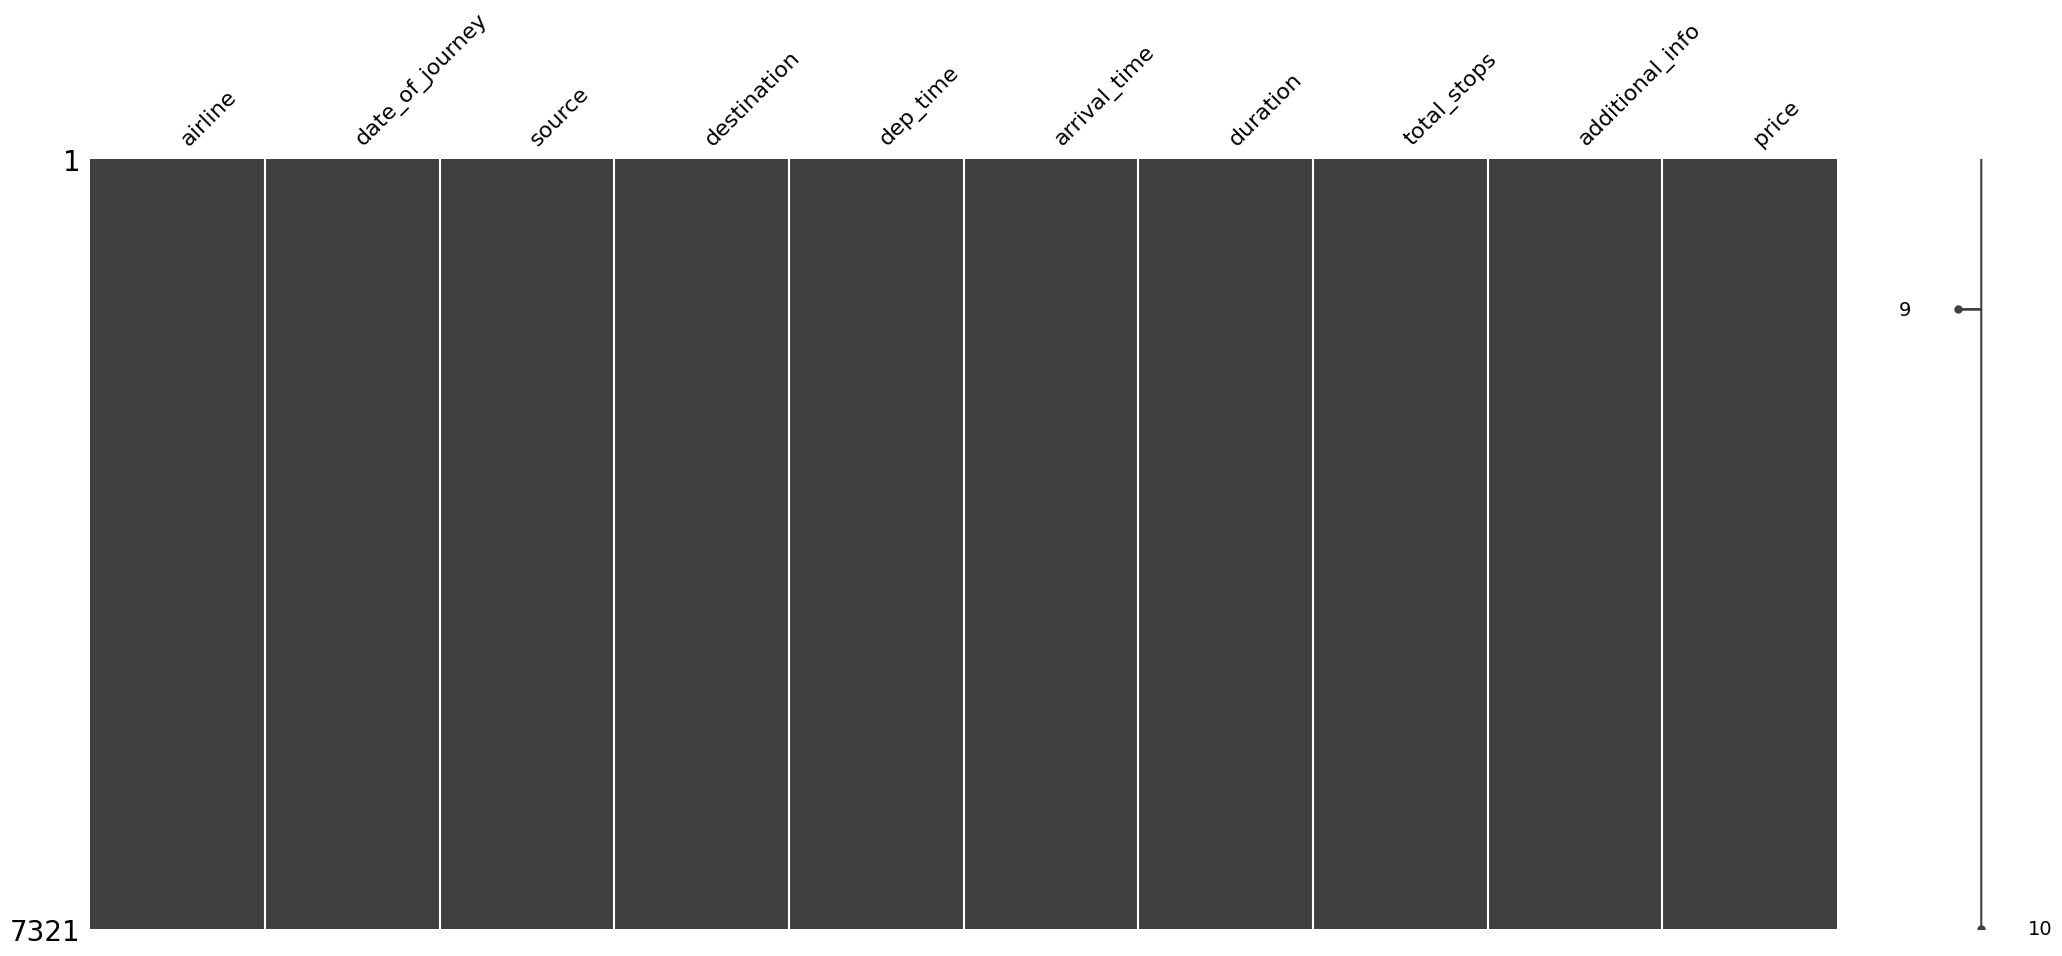

In [10]:
import missingno as msno
msno.matrix(train)

<Axes: >

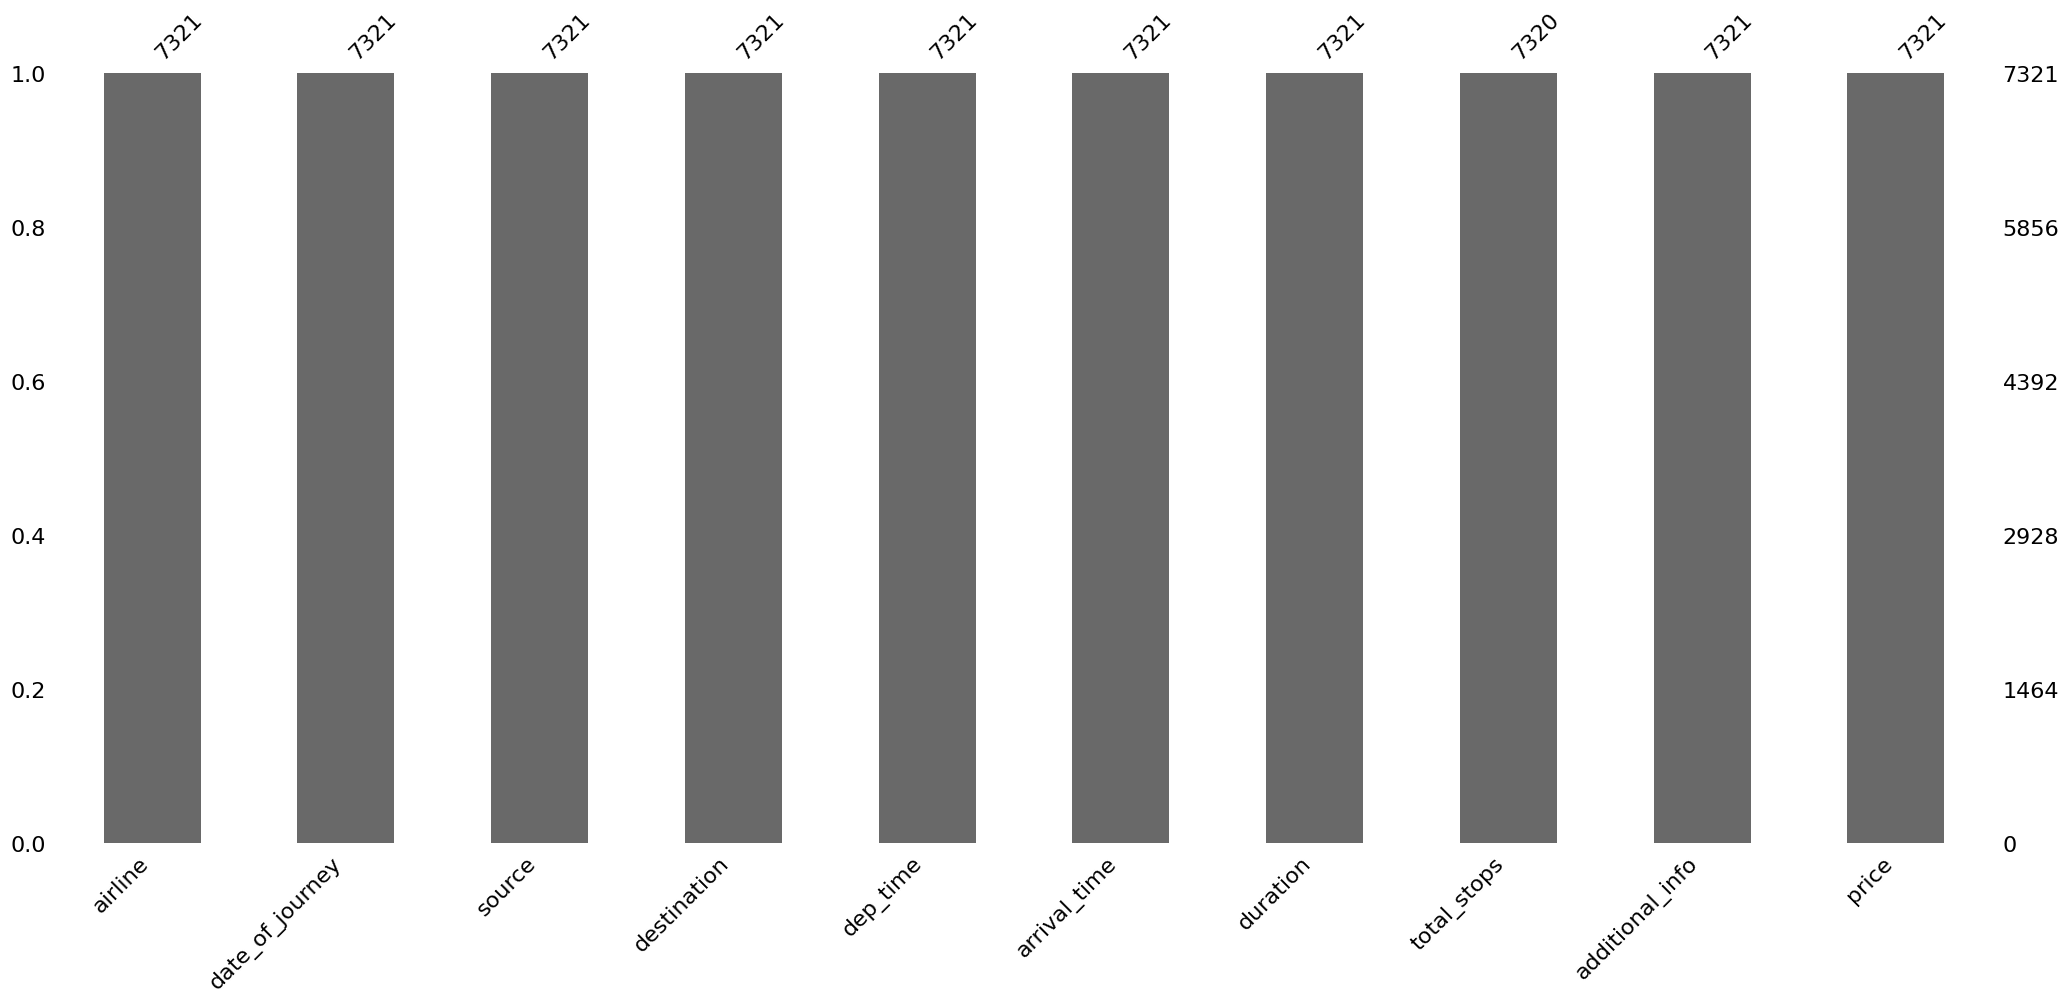

In [11]:
msno.bar(train)

## High-Level-Outlier-Analysis

In [12]:
from sklearn.ensemble import IsolationForest
(
    train
    .assign(outlier= IsolationForest(n_estimators=10,random_state=42).fit_predict(train.drop(columns="price").select_dtypes(include="number").fillna(train["total_stops"].mean())))
    .query("outlier == -1")
    .duration
    .describe()
)

count    2974.000000
mean      859.633490
std       641.702846
min        75.000000
25%       145.000000
50%       985.000000
75%      1430.000000
max      2860.000000
Name: duration, dtype: float64

## Pair Plots

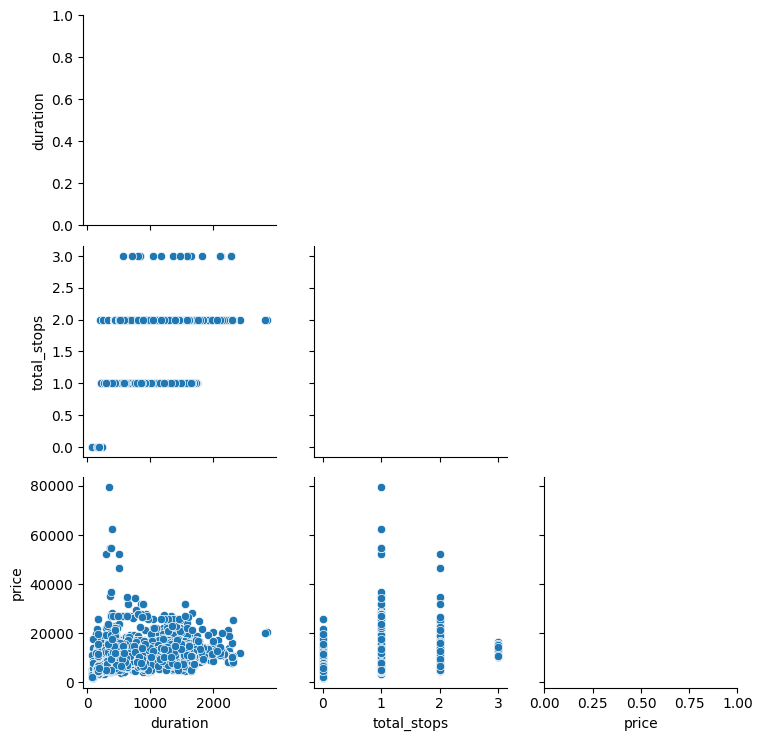

In [13]:
sns.PairGrid(data=train.select_dtypes(include="number"),corner=True).map_lower(sns.scatterplot)


## Correlation Analysis

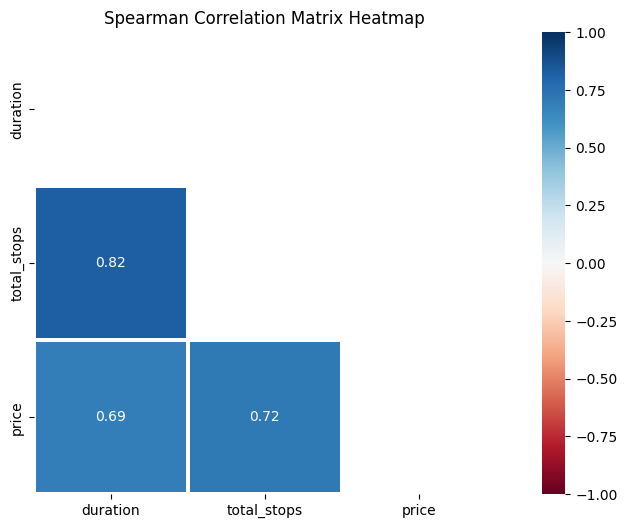

In [14]:
def correlation_heatmap(data,
                        figsize=(12, 6),
                        method="spearman",
                        cmap="RdBu"):
  cm = data.corr(method=method, numeric_only=True)

  mask = np.zeros_like(cm, dtype=bool)
  mask[np.triu_indices_from(mask)] = True

  fig, ax = plt.subplots(figsize=figsize)
  hm = sns.heatmap(
      cm,
      vmin=-1,
      vmax=1,
      cmap=cmap,
      center=0,
      annot=True,
      fmt=".2f",
      linewidths=1.5,
      square=True,
      mask=mask,
      ax=ax
  )

  ax.set(title=f"{method.title()} Correlation Matrix Heatmap")
correlation_heatmap(train)

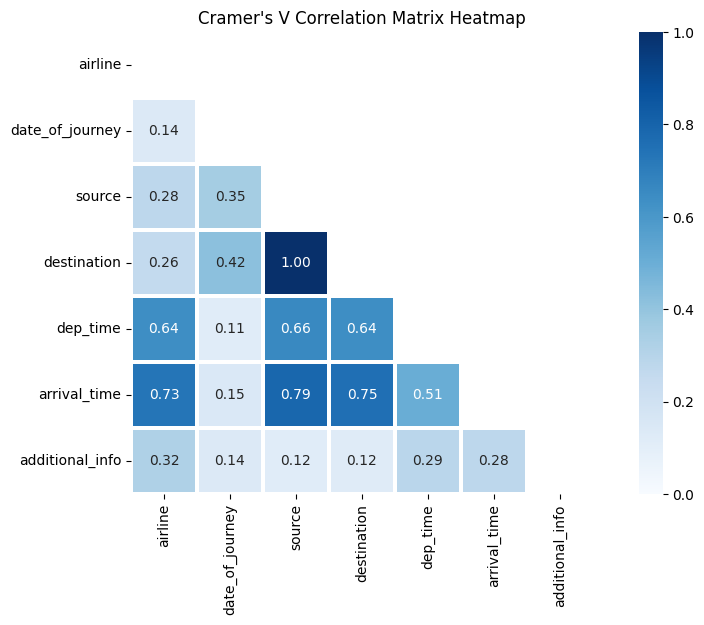

In [15]:
from scipy import stats
def cramers_v(data, var1, var2):
  ct = pd.crosstab(
      data.loc[:, var1],
      data.loc[:, var2]
  )
  r, c = ct.shape
  n = ct.sum().sum()
  chi2 = stats.chi2_contingency(ct).statistic
  phi2 = chi2 / n

  # bias correction
  phi2_ = max(0, phi2 - ((r - 1) * (c - 1) / (n - 1)))
  r_ = r - (((r - 1) ** 2) / (n - 1))
  c_ = c - (((c - 1) ** 2) / (n - 1))

  return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))

def cramersV_heatmap(data, figsize=(12, 6), cmap="Blues"):
  cols = data.select_dtypes(include="O").columns.to_list()

  matrix = (
      pd
      .DataFrame(data=np.ones((len(cols), len(cols))))
      .set_axis(cols, axis=0)
      .set_axis(cols, axis=1)
  )

  for col1 in cols:
    for col2 in cols:
      if col1 != col2:
        matrix.loc[col1, col2] = cramers_v(data, col1, col2)

  mask = np.zeros_like(matrix, dtype=bool)
  mask[np.triu_indices_from(mask)] = True
  
  fig, ax = plt.subplots(figsize=figsize)
  hm = sns.heatmap(
      matrix,
      vmin=0,
      vmax=1,
      cmap=cmap,
      annot=True,
      fmt=".2f",
      square=True,
      linewidths=1.5,
      mask=mask,
      ax=ax
  )
  ax.set(title="Cramer's V Correlation Matrix Heatmap")
  
cramersV_heatmap(train)

## Detailed Analysis

In [16]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

**Airline**

In [17]:
script_.cat_summary(train,"airline")

0             GoAir
1          SpiceJet
2          Air Asia
3       Jet Airways
4            IndiGo
           ...     
7316         IndiGo
7317    Jet Airways
7318         IndiGo
7319         IndiGo
7320    Jet Airways
Name: airline, Length: 7321, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 7,321 / 7,321 rows


,
count,7321
unique,8
top,Jet Airways
freq,2595


,count,percentage
category,,
Jet Airways,2595,0.354460
IndiGo,1430,0.195329
Air India,1168,0.159541
Multiple carriers,847,0.115695
SpiceJet,562,0.076765
Vistara,355,0.048491
Air Asia,229,0.031280
GoAir,135,0.018440


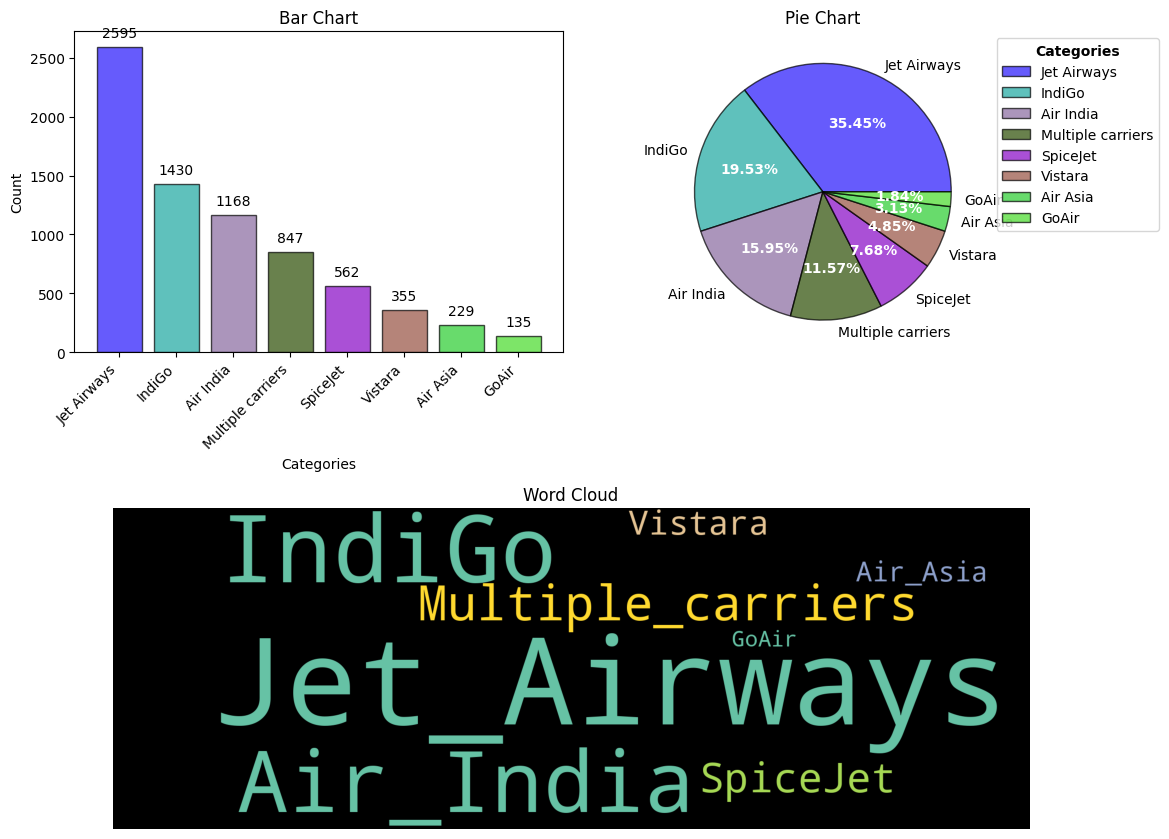

In [18]:
script_.cat_univar_plots(train,"airline")


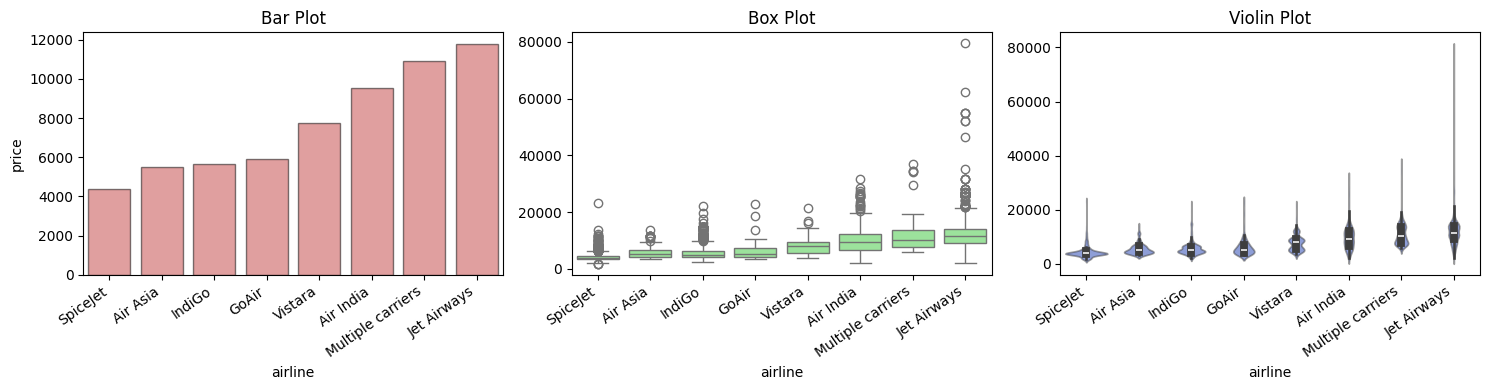

In [19]:
script_.num_cat_bivar_plots(data=train,num_var="price",cat_var="airline")

In [20]:
script_.num_cat_hyp_testing(train,"price","airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 559.4779917247215
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3369.0951781616973
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


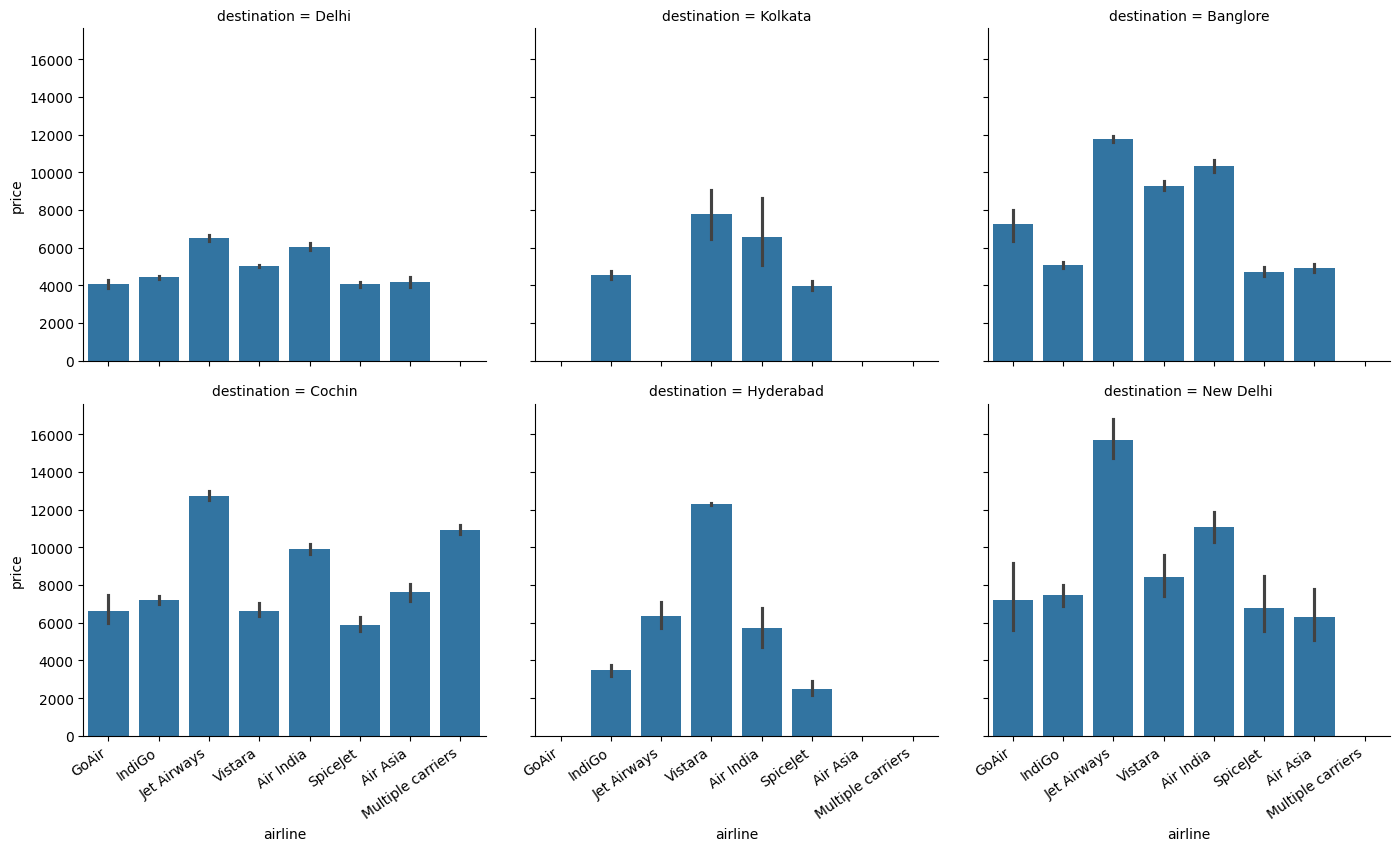

In [21]:
airline_grid=sns.FacetGrid(
    data=train,
    col="destination",
    sharey=True,
    height=4,
    aspect=1.2,
    
    col_wrap=3
).map(sns.barplot,"airline","price")
for ax in airline_grid.axes[3:]:
    script_.rotate_xlabels(ax)

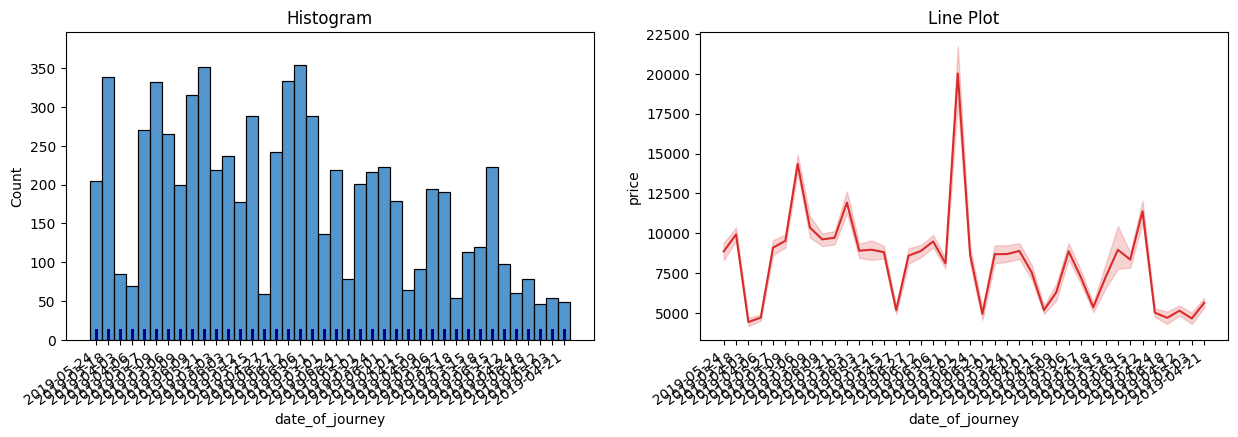

In [22]:
script_.dt_univar_plots(
    data=train,
    var="date_of_journey",
    target="price"
)

<Axes: xlabel='month'>

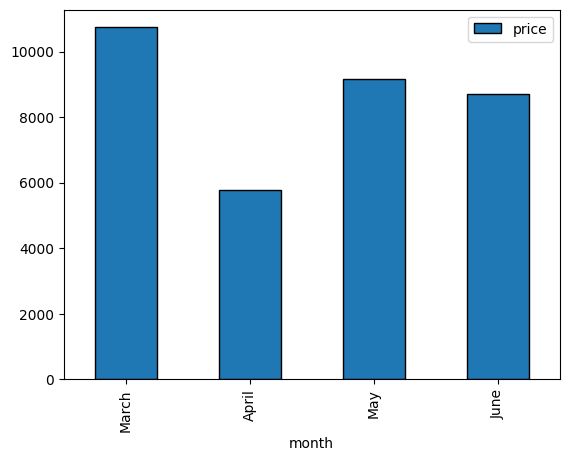

In [23]:
(
    train
    .assign(
        date_of_journey=pd.to_datetime(train.date_of_journey)
    )
    .groupby(pd.Grouper(key="date_of_journey",freq="m")).price.mean()
    .to_frame()
    .set_axis(["March","April","May","June"],axis=0)
    .rename_axis(index="month")
    .plot(
        kind="bar",
        edgecolor="black"
    )
)

<Axes: xlabel='week'>

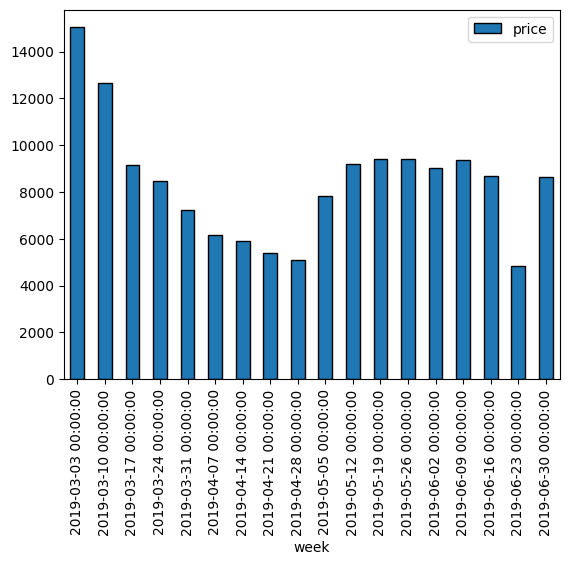

In [24]:
(
    train
    .assign(
        date_of_journey=pd.to_datetime(train.date_of_journey)
    )
    .groupby(pd.Grouper(key="date_of_journey",freq="w")).price.mean()
    .to_frame()
    #.set_axis(["March","April","May","June"],axis=0)
    .rename_axis(index="week")
    .plot(
        kind="bar",
        edgecolor="black"
    )
)

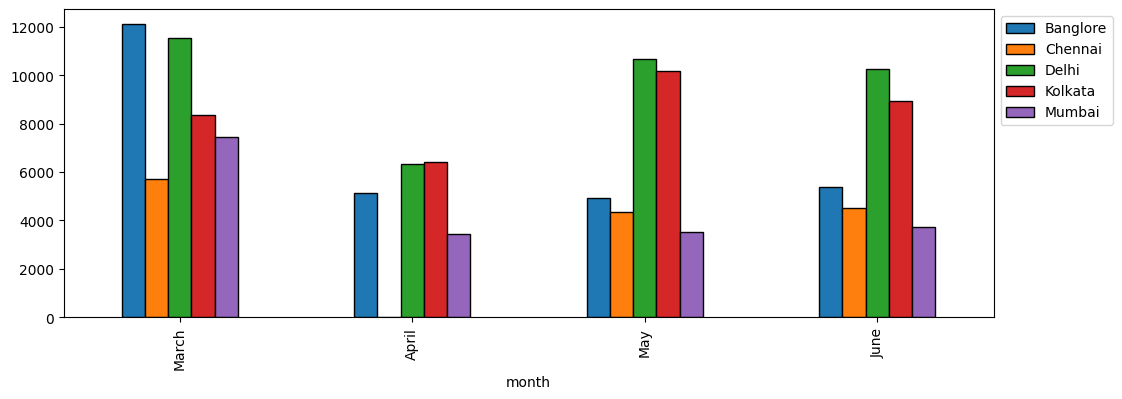

In [25]:
(
	train
    .assign(
        date_of_journey=pd.to_datetime(train.date_of_journey)
    )
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

In [26]:
train.dep_time

0       11:40:00
1       09:45:00
2       10:20:00
3       08:00:00
4       16:55:00
          ...   
7316    08:30:00
7317    07:00:00
7318    10:35:00
7319    05:35:00
7320    08:25:00
Name: dep_time, Length: 7321, dtype: object

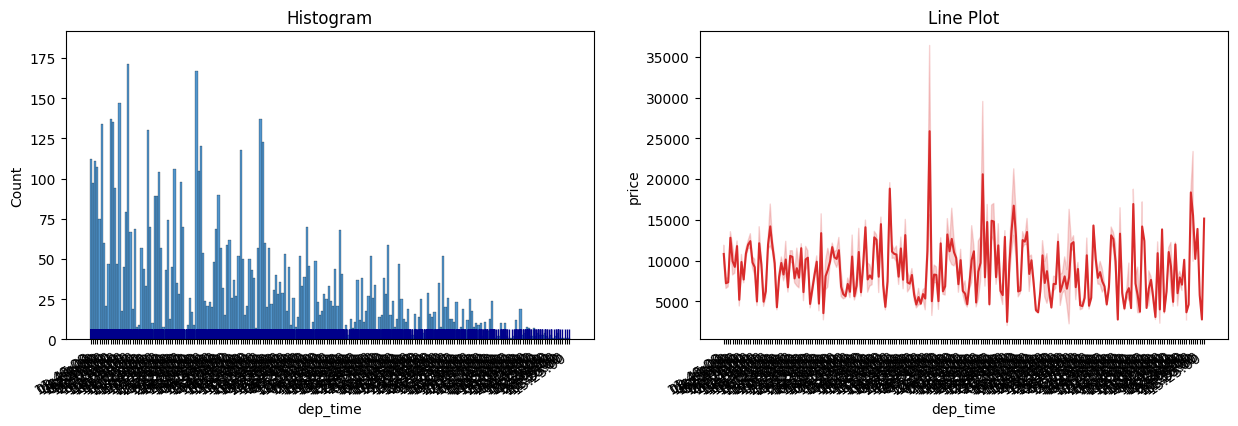

In [27]:
script_.dt_univar_plots(train,"dep_time","price")

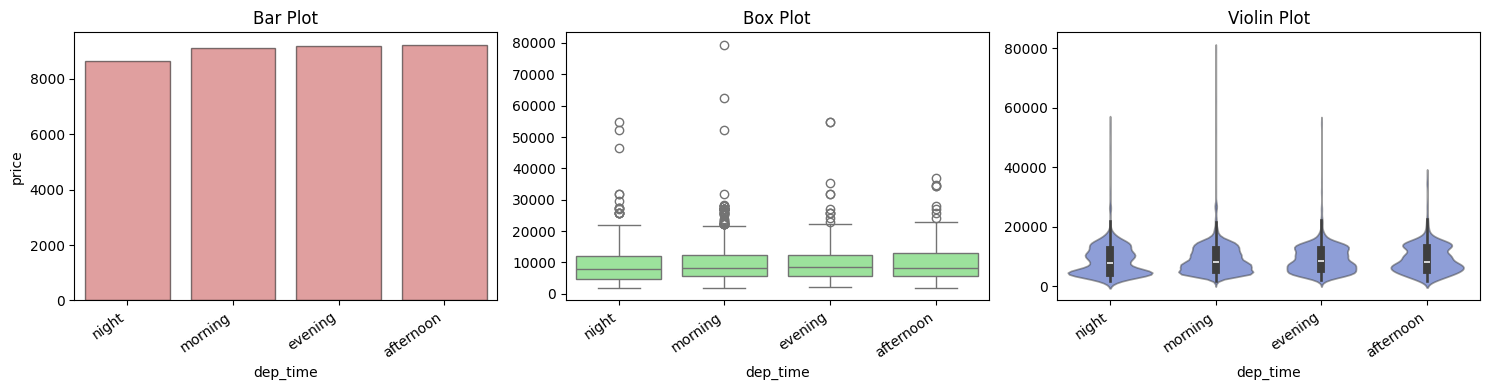

In [28]:

(
	train
    .assign(dep_time=pd.to_datetime(train.dep_time),)
	.assign(
        
        dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(script_.num_cat_bivar_plots, "price", "dep_time")
)

In [29]:
script_.num_summary(train,"duration")

0        170
1        135
2        155
3        660
4        180
        ... 
7316     170
7317     860
7318     300
7319     195
7320    1215
Name: duration, Length: 7321, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 7,321 / 7,321 rows


,value
percentile,
0,75.0
5,90.0
10,145.0
25,170.0
50,510.0
75,915.0
90,1430.0
95,1595.0
99,1830.0


,value
mean,632.240814
trimmed mean (5%),599.284413
trimmed mean (10%),570.934779
median,510.000000


,value
var,248463.833941
std,498.461467
IQR,745.000000
mad,340.000000
coef_variance,0.788404


,value
skewness,0.881543
kurtosis,-0.092218


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 2.659565171078547e-58
Test Statistic       : 0.8883463371331141
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 266.00309289024426
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


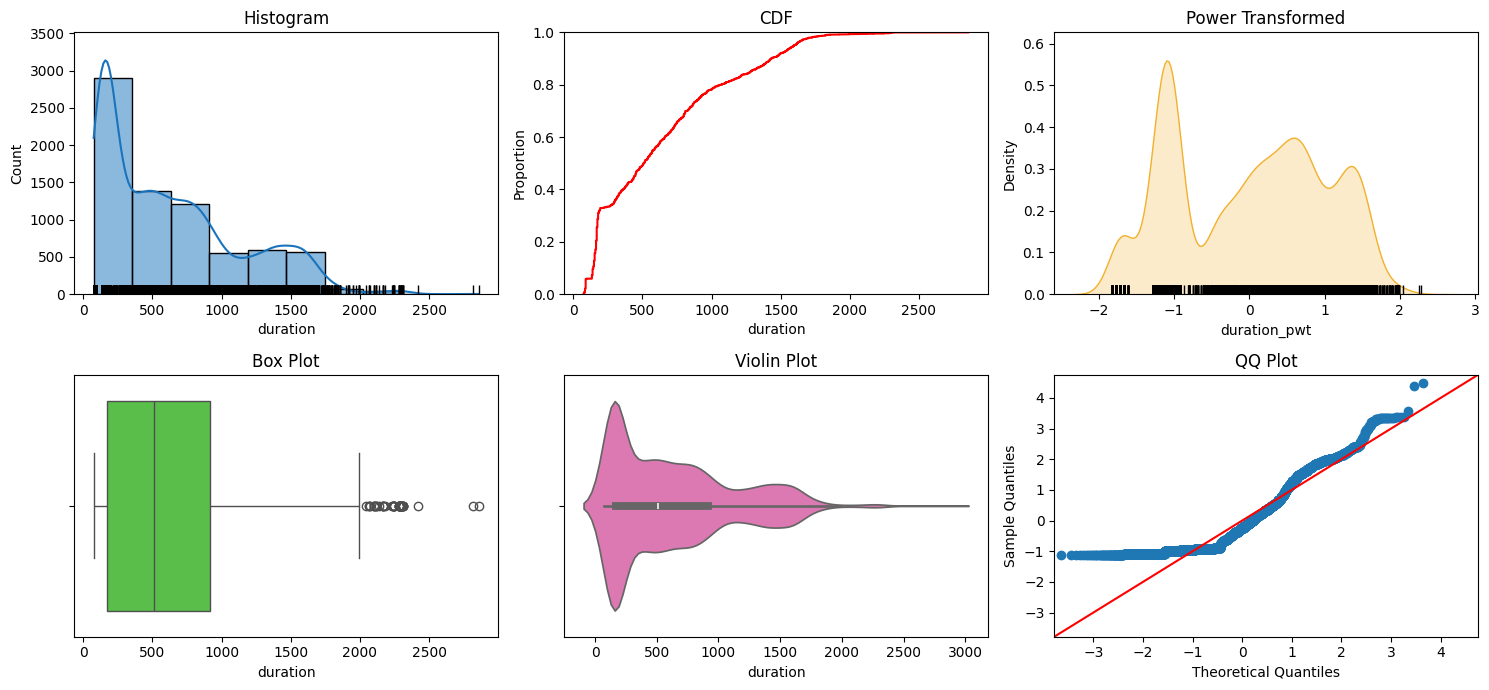

In [30]:
script_.num_univar_plots(train,"duration")

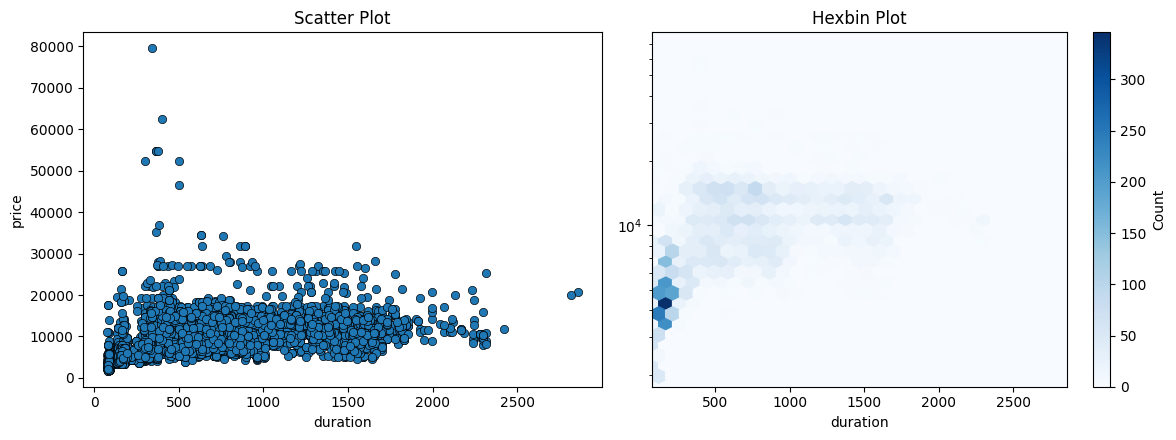

In [31]:
script_.num_bivar_plots(train,"duration","price",
                        hexbin_kwargs=dict(
                            yscale="log",
                            gridsize=30,
                            cmap="Blues"
                        ))

In [32]:
script_.num_num_hyp_testing(train,"price","duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.4962749561287929
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6912991717073875
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


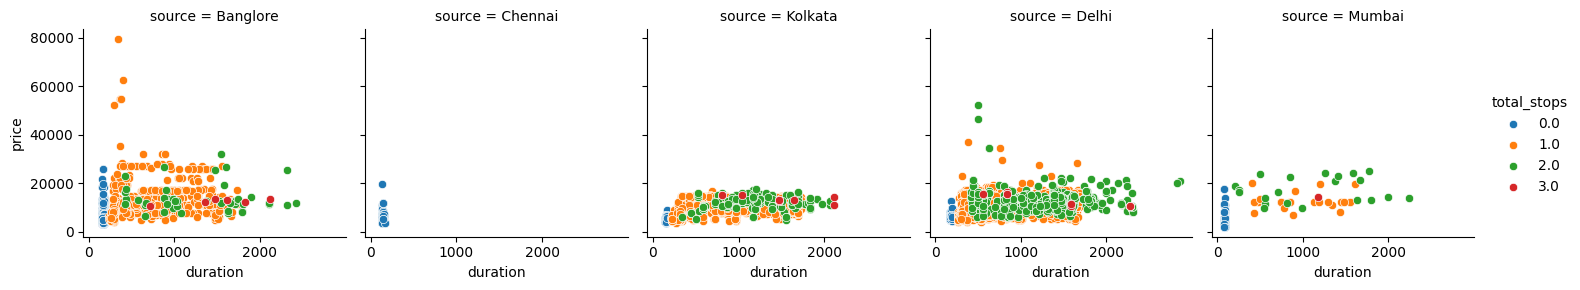

In [33]:
duration_grid=sns.FacetGrid(
    data=train,
    col="source",
    hue="total_stops",
    sharey=True
)
duration_grid.map(sns.scatterplot,"duration","price")
duration_grid.add_legend()

In [36]:
script_.get_iqr_outliers(train,"duration")

Lower Limit : -947.5
Upper Limit : 2032.5


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3933,Jet Airways,2019-03-21,Delhi,Cochin,18:20:00,04:25:00,2045,2.0,No Info,13082
2437,Air India,2019-05-01,Kolkata,Banglore,05:50:00,16:15:00,2065,2.0,No Info,10991
7297,Air India,2019-05-15,Kolkata,Banglore,05:50:00,16:15:00,2065,2.0,No Info,12723
1092,Jet Airways,2019-03-06,Delhi,Cochin,17:55:00,04:25:00,2070,2.0,No Info,17072
5495,Air India,2019-03-18,Banglore,New Delhi,11:05:00,22:10:00,2105,2.0,No Info,11161
7037,Air India,2019-03-03,Banglore,New Delhi,11:05:00,22:10:00,2105,2.0,No Info,11948
2777,Air India,2019-03-03,Banglore,New Delhi,11:05:00,22:10:00,2105,2.0,No Info,11791
6514,Air India,2019-05-12,Kolkata,Banglore,12:00:00,23:15:00,2115,3.0,No Info,10991
7200,Air India,2019-03-24,Kolkata,Banglore,12:00:00,23:15:00,2115,3.0,No Info,14221
5667,Air India,2019-03-12,Banglore,New Delhi,06:45:00,18:05:00,2120,3.0,No Info,13387
